In [ ]:
import pandas as pd
import math
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

In [ ]:
df = yf.download('VUSA', start='2023-06-01', end='2024-07-25')
# df.reset_index(drop=False, inplace=True)
# df = df.reset_index(drop=True)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-01,177.699997,180.119995,176.929993,180.089996,179.138626,68901800
2023-06-02,181.029999,181.779999,179.259995,180.949997,179.994080,61945900
2023-06-05,182.630005,184.949997,178.039993,179.580002,178.631332,121946500
2023-06-06,179.970001,180.119995,177.429993,179.210007,178.263290,64848400
2023-06-07,178.440002,181.210007,177.320007,177.820007,176.880630,61944600
...,...,...,...,...,...,...
2024-05-24,188.820007,190.580002,188.039993,189.979996,189.979996,36294600
2024-05-28,191.509995,193.000000,189.100006,189.990005,189.990005,52280100
2024-05-29,189.610001,192.250000,189.509995,190.289993,190.289993,53068000


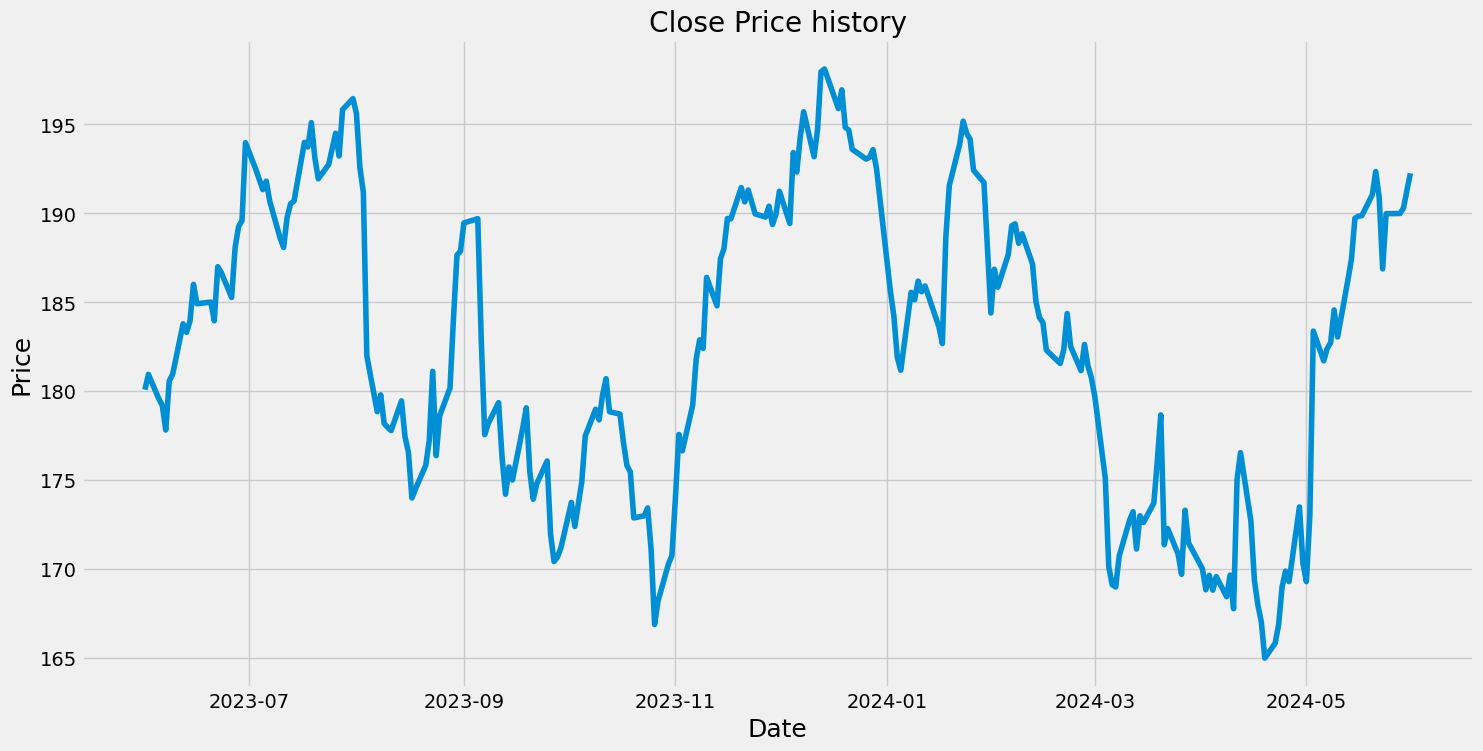

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.title('Close Price history')
plt.ylabel('Price',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.show()

In [ ]:
df.shape

(252, 6)

In [ ]:
data = df.filter(['Close'])

dataset = data.values

#Scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# training data
training_data_len = math.ceil(len(dataset) * 0.8)
train_data = scaled_data[0:training_data_len, :]

test_data = scaled_data[training_data_len-60:  ,:]

#Split
x_train = []
y_train = []
x_test = []
y_test = dataset[training_data_len:, :]

for i in range (60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

for i in range (60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# convert to numpy to train LSTM
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)


In [ ]:
# reshaping data for LSTM to be 3 dimentional (no. sample, no. timestamps, no. features)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


In [ ]:
# LSTm model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

142/142 [==============================] - 8s 30ms/step - loss: 0.0403


In [ ]:
# Get teh model prediction
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


2/2 [==============================] - 1s 15ms/step


In [ ]:
# Evaluation
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.2342941284179687

<ipython-input-22-97780e54034f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


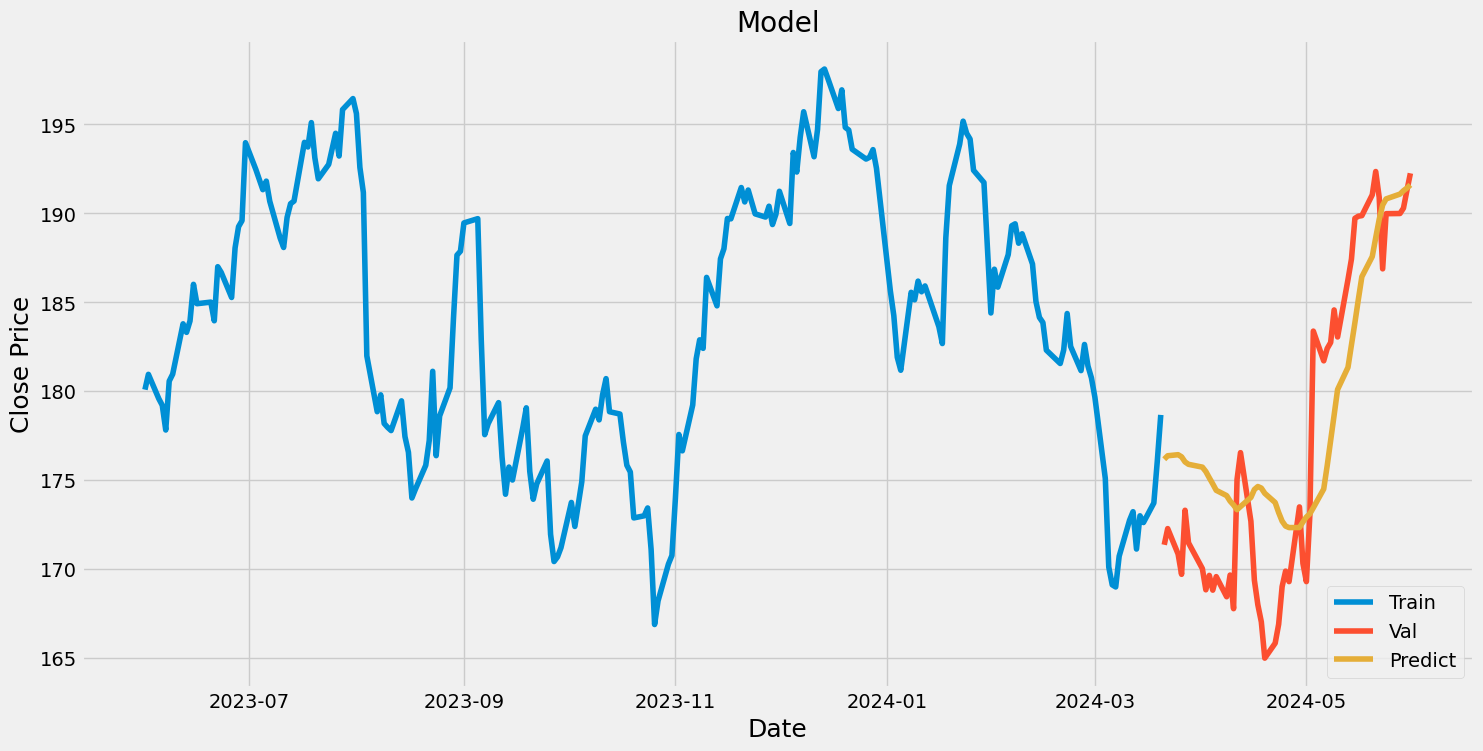

In [ ]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val', 'Predict'], loc = 'lower right')
plt.show()

In [ ]:
valid

,Close,Predictions
Date,,
2024-03-21,171.369995,176.178650
2024-03-22,172.279999,176.374390
2024-03-25,170.850006,176.434021
2024-03-26,169.710007,176.315094
2024-03-27,173.309998,176.028900
2024-03-28,171.479996,175.893311
2024-04-01,170.029999,175.734802
2024-04-02,168.839996,175.487030
2024-04-03,169.649994,175.132233


In [ ]:
apple_quote = yf.download('AAPL', start='2023-06-03', end='2024-07-05')
new_df = apple_quote.filter(['Close'])
# Get the last 60 days closing price
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 29ms/step
[[213.1602]]


In [ ]:
apple_quote

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-05,182.630005,184.949997,178.039993,179.580002,178.631332,121946500
2023-06-06,179.970001,180.119995,177.429993,179.210007,178.263290,64848400
2023-06-07,178.440002,181.210007,177.320007,177.820007,176.880646,61944600
2023-06-08,177.899994,180.839996,177.460007,180.570007,179.616104,50214900
2023-06-09,181.500000,182.229996,180.630005,180.960007,180.004044,48870700
...,...,...,...,...,...,...
2024-06-27,214.690002,215.740005,212.350006,214.100006,214.100006,49772700
2024-06-28,215.770004,216.070007,210.300003,210.619995,210.619995,82542700
2024-07-01,212.089996,217.509995,211.919998,216.750000,216.750000,60402900


In [ ]:
apple_quote2 = yf.download('AAPL', start='2024-07-05', end='2024-07-06')
print(apple_quote2['Close'])

[*********************100%%**********************]  1 of 1 completed

Date
2024-07-05    226.339996
Name: Close, dtype: float64
